# Lab 10
From just 10 pixels from an image of a face, how well can we reconstruct the rest of the face?

In [1]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [2]:
#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [3]:
#load data
fea = pd.read_csv('faces_fea.csv',header=None)
fea/=fea.max().max()
faceW = 32
faceH = 32

In [4]:
#input data: 10 pixels in middle column of the face

num_pixels = 10
column = 15

xdata = []
for face in np.array(fea):
    matrix = np.reshape(face,(faceH,faceW)).T
    xdata.append(matrix[:num_pixels, column])


In [5]:
#target data: PC modes of full face

#do PCA using built-in library
n_modes = np.shape(fea)[1]
pca = PCA(n_components = n_modes)
fea_demean = fea.sub(fea.mean(axis=1), axis=0)
PCs = pca.fit_transform(fea)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

ydata = np.squeeze(PCs[:,:1]) 

In [6]:
#divide into training and testing data
ntrain = 2000 #number of faces to use for training
x_train = xdata[:ntrain]
y_train = ydata[:ntrain]
x_test = xdata[ntrain:]
y_test = ydata[ntrain:]

#normalize wrt training set
xmean = np.mean(x_train,axis=0)
xstd = np.std(x_train,axis=0)
ymean = np.mean(y_train,axis=0)
ystd = np.std(y_train,axis=0)

x_train-=xmean
x_train/=xstd
x_test-=xmean
x_test/=xstd
y_train-=ymean
y_train/=ystd
y_test-=ymean
y_test/=ystd

In [7]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: something else!

##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 12 #maximum number of hidden neurons to loop through
max_hidden_layers = 1 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.001
max_iter = 1500 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 BEST: 1 hidden layers, 11 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 BEST: 1 hidden layers, 12 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		

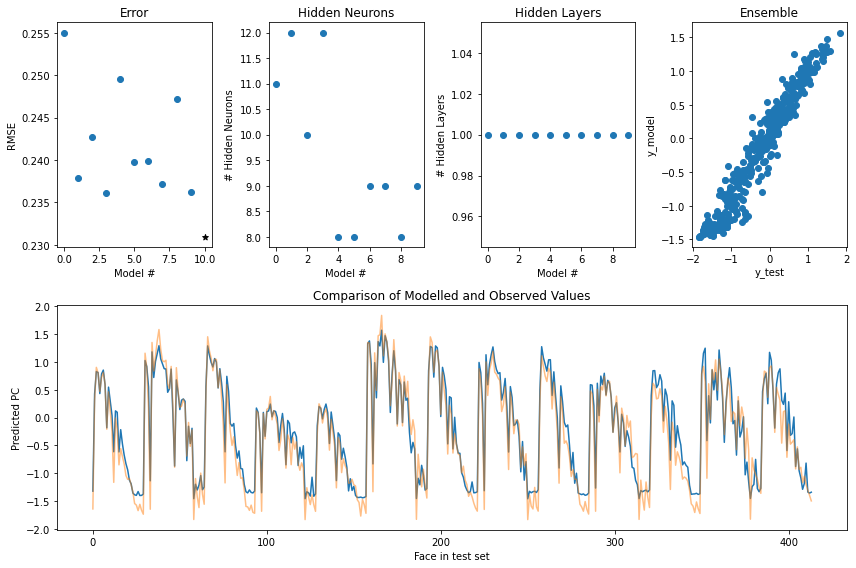

In [8]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean)
plt.plot(y_test,alpha = 0.5)
plt.xlabel('Face in test set')
plt.ylabel('Predicted PC')
plt.title('Comparison of Modelled and Observed Values')

plt.tight_layout()

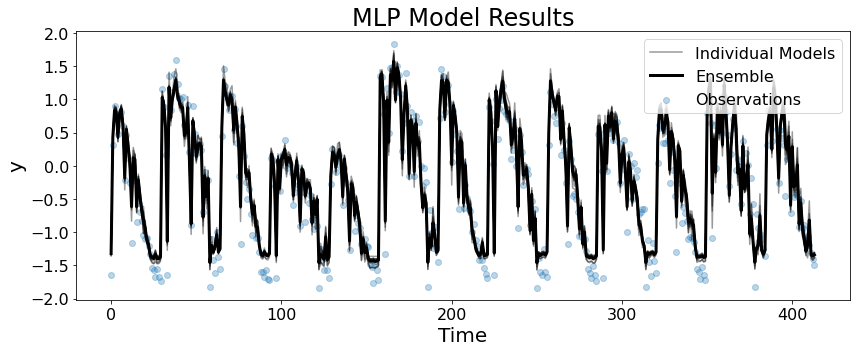

In [9]:
#visualize individual model runs


plt.figure(figsize = (12,5))

plt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0,alpha = 0.3)
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[0]),color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[1:]),color = 'k',alpha = 0.4,zorder=1) #plot remaining ensemble members without labels for a nicer legend
plt.plot(range(len(y_test)),y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2, linewidth = 3)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

plt.show()